Caption: a brown and white dog sitting on top of a wooden table 


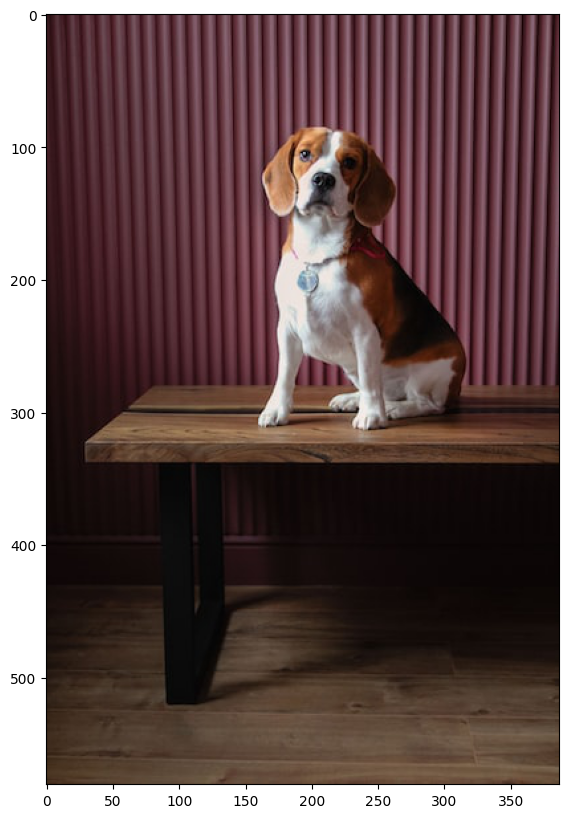

In [2]:
#@title Caption custom images
#@markdown Enter the URL of any image.

###############################################################################################################
# Import Packages

import os
import cv2
import sys
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from collections import Counter
from random import choice, sample
from PIL import Image
import matplotlib.image as mpimg
from statistics import mean
import skimage.transform

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.nn.utils.rnn import pack_padded_sequence

from urllib.request import urlretrieve

import warnings
warnings.filterwarnings('ignore')

###############################################################################################################
# Network

class Encoder(nn.Module):

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()

        self.enc_image_size = encoded_image_size

        # pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101(pretrained=True)

        # Remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image using adaptive avg pool to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        :param images: images, a tensor of dim (batch_size, 3, image_size, image_size)
        :return: encoded images, a tensor of dim (batch_size, encoded_image_size, encoded_image_size, 2048)
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=False):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Boolean
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        # If fine-tuning, fine-tune convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune

class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoder's output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights for weighted avg (attention )

    def forward(self, encoder_out, decoder_hidden):
        """
        :param encoder_out: encoder's output, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights (attention)
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)))  # (batch_size, num_pixels, 1)
        alpha = self.softmax(att)  # (batch_size, num_pixels, 1)
        attention_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha.squeeze(2)  # (batch_size, encoder_dim), (batch_size, num_pixels)

class DecoderWithAttention(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: feature size of decoder's RNN output
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size

        # attention network
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(0.5)

        # lstm cell takes prev word output (embed_dim) and also the weighted encoded image (encoder_dim)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)   # (batch_size, encoder_dim)

        h = self.init_h(mean_encoder_out)            # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)            # (batch_size, decoder_dim)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lens):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lens: caption lengths, a tensor of dimension (batch_size, 1)
        """

        batch_size = encoder_out.size(0)

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, self.encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort the encoded image, caption and length by decreasing caption length
        caption_lens, sort_index = caption_lens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_index]
        encoded_captions = encoded_captions[sort_index]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are caption lengths - 1
        decode_lens = (caption_lens - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lens), self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device)

        # At each time-step, decode by attention-weighing the encoder's output
        # based on the decoder's previous hidden state output then generate a
        # new word in the decoder with the previous word and the attention weighted encoding.
        for t in range(max(decode_lens)):
            # For each time step the batch size changes
            batch_size_t = sum([l > t for l in decode_lens])

            # get attention weighted encodings (batch_size_t, encoder_dim)
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # sigmoid activated gate (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            # decoder input is formed from the embeddings of the current (t) word and the attention weighted encoding
            decoder_input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            h, c = self.decode_step(decoder_input, (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)

            # next word prediction for current word
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)

            # save the prediction and alphas at every time step (t)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lens, alphas, sort_index

def caption_test_data(encoder, decoder, word_map, beam_size=7, Visualize_Attention = False):
    """
    Randomly samples the test dataset and plots attention
    along with the caption.
    """

    k = beam_size
    vocab_size = len(word_map)

    # dict mapping int to word
    rev_word_map = {value: word for word, value in word_map.items()}

    # Read the image
    image_array = np.array(Image.open('pic.png'))
    # convert grayscale to RGB format
    if len(image_array.shape) == 2:
        image_array = image_array[:, :, np.newaxis]
        image_array = np.concatenate([image_array, image_array, image_array], axis=2)
    image_array = cv2.resize(image_array, (336, 336))

    # sanity checks
    assert image_array.shape == (336, 336, 3)
    assert np.max(image_array) <= 255

    convert_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    image = (normalize(convert_to_tensor(image_array)))

    idx = random.randint(0, 25000)  # randomly sample the test dataset
    encoder_out = encoder(image.to(device).unsqueeze(0))  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoded image
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    top_k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    top_k_seqs = top_k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    # initially s will be k, s will eventually get reduced to 0
    while True:

        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)

        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add the current scores to the prev scores
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        # Considering only the first sequence as all the scores are alike
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        top_k_seqs_alpha = torch.cat([top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break

        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    # select the sequence with maximum score
    index = complete_seqs_scores.index(max(complete_seqs_scores))
    sequence = complete_seqs[index]
    alphas = complete_seqs_alpha[index]
    caption = [rev_word_map[index] for index in sequence]

    if Visualize_Attention:
        # Plot the image and attention
        plt.figure(figsize=(30,20))
        for word in range(len(caption)):   # +2 for <start> and <end>
            # Plot the image
            plt.subplot(np.ceil(len(caption) / 4), 4, word + 1)
            plt.text(0, 1, '%s' % (caption[word]), color='black', backgroundcolor='white', fontsize=30)
            plt.imshow(image_array)

            # Plot the attention
            current_alpha = alphas[word]
            alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
            if word == 0:
                plt.imshow(alpha, alpha=0)
            else:
                plt.imshow(alpha, alpha=0.8)
            plt.set_cmap('gray')
            plt.axis('off')
        plt.show()

    else:
        plt.figure(figsize=(10,10))
        caption = ' '.join(word for word in caption[1:-1])
        plt.imshow(np.array(Image.open('pic.png')))
        print('Caption: %s ' %caption)
###############################################################################################################
# Download pretrained weights
if not os.path.exists('image_captioning_pred.pth'):
    !gdown --id 11Cchips2b_LAQLUgP9x8Cey9lJNmcdFz

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('image_captioning_pred.pth', map_location=device)
encoder = checkpoint['encoder']
decoder = checkpoint['decoder']
word_map = checkpoint['wordmap']

###############################################################################################################
# Download and caption Image
URL = 'https://images.unsplash.com/photo-1611306133736-56a3b973b2cc?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=387&q=80' #@param {type:"string"}
Beam_Size =  3#@param {type: "number"}
Visualize_Attention = False #@param {type:"boolean"}

assert Beam_Size < 10

urlretrieve(URL,'pic.png')
caption_test_data(encoder, decoder, word_map, Beam_Size, Visualize_Attention)